<a href="https://colab.research.google.com/github/marclamberts/football-analysis/blob/main/Ghost_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


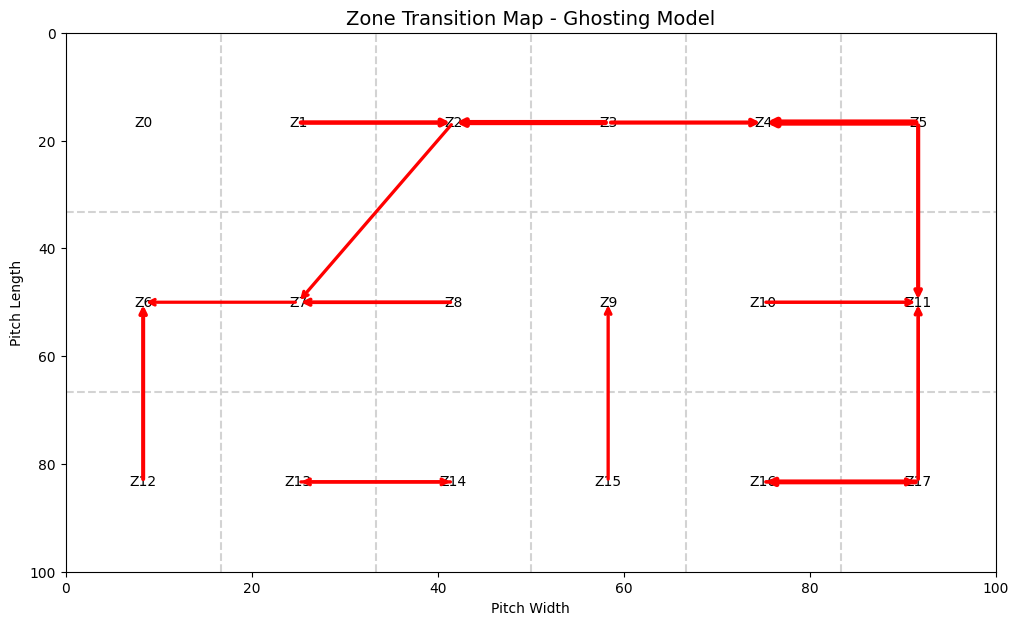


🔍 Player: 5gng3f8q1qqlzt3gwafu7yfl6
Z9 ➜ Z14 | ΔxT = 0.010
Z14 ➜ Z14 | ΔxT = 0.000
Z14 ➜ Z14 | ΔxT = 0.000
Z14 ➜ Z8 | ΔxT = -0.030
Z8 ➜ Z14 | ΔxT = 0.030
Z14 ➜ Z11 | ΔxT = 0.030
Z11 ➜ Z11 | ΔxT = 0.000
Z11 ➜ Z17 | ΔxT = 0.080
Z17 ➜ Z16 | ΔxT = -0.050
Z16 ➜ Z10 | ΔxT = -0.050
Z10 ➜ Z10 | ΔxT = 0.000
Z10 ➜ Z11 | ΔxT = 0.020
Z11 ➜ Z15 | ΔxT = 0.000
Z15 ➜ Z17 | ΔxT = 0.080
Z17 ➜ Z13 | ΔxT = -0.130
Z13 ➜ Z15 | ΔxT = 0.050
Z15 ➜ Z11 | ΔxT = 0.000
Z11 ➜ Z14 | ΔxT = -0.030
Z14 ➜ Z14 | ΔxT = 0.000
Z14 ➜ Z8 | ΔxT = -0.030
Z8 ➜ Z8 | ΔxT = 0.000
Z8 ➜ Z16 | ΔxT = 0.090
Z16 ➜ Z16 | ΔxT = 0.000
Z16 ➜ Z9 | ΔxT = -0.070
Z9 ➜ Z16 | ΔxT = 0.070
Z16 ➜ Z15 | ΔxT = -0.030
Z15 ➜ Z17 | ΔxT = 0.080
Z17 ➜ Z17 | ΔxT = 0.000
Z17 ➜ Z16 | ΔxT = -0.050
Z16 ➜ Z11 | ΔxT = -0.030
Z11 ➜ Z17 | ΔxT = 0.080
Z17 ➜ Z16 | ΔxT = -0.050
Z16 ➜ Z9 | ΔxT = -0.070
Z9 ➜ Z3 | ΔxT = -0.040
Z3 ➜ Z16 | ΔxT = 0.110
Z16 ➜ Z14 | ΔxT = -0.060
Z14 ➜ Z15 | ΔxT = 0.030
Z15 ➜ Z9 | ΔxT = -0.040
Z9 ➜ Z8 | ΔxT = -0.020
Z8 ➜ Z8 | ΔxT = 0.000
Z8 ➜ 

In [3]:
# --- STEP 1: MOUNT GOOGLE DRIVE & LOAD DATA ---
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 🔁 Replace with your correct file path inside Google Drive
file_path = '/content/drive/MyDrive/Outswinger FC/Eredivisie Women 2024-2025/Utrecht 1-0 Feyenoord.csv'
df = pd.read_csv(file_path)

# --- STEP 2: FILTER EVENTS FOR FEYENOORD ---
feyenoord_id = 'aoaced38v02b2trzucbou0ulz'  # Feyenoord team ID
feyenoord_events = df[(df['contestantId'] == feyenoord_id) & (df['x'] > 0) & (df['y'] > 0)].copy()

# --- STEP 3: ASSIGN ZONES (6x3 grid = 18 zones) ---
def assign_zone(x, y, x_bins=6, y_bins=3):
    x_zone = min(int(x / (100 / x_bins)), x_bins - 1)
    y_zone = min(int(y / (100 / y_bins)), y_bins - 1)
    return y_zone * x_bins + x_zone

feyenoord_events['zone'] = feyenoord_events.apply(lambda row: assign_zone(row['x'], row['y']), axis=1)

# --- STEP 4: TRANSITION MATRIX (Markov) ---
zone_sequence = feyenoord_events['zone'].tolist()
transition_counts = np.zeros((18, 18))

for i in range(len(zone_sequence) - 1):
    from_zone = zone_sequence[i]
    to_zone = zone_sequence[i + 1]
    transition_counts[from_zone, to_zone] += 1

transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)
transition_probs = np.nan_to_num(transition_probs)

# --- STEP 5: PLOT TRANSITIONS ON PITCH ---
fig, ax = plt.subplots(figsize=(12, 7))

# Draw pitch grid (6x3)
for x in range(1, 6):
    ax.axvline(x=100/6*x, color='lightgrey', linestyle='--')
for y in range(1, 3):
    ax.axhline(y=100/3*y, color='lightgrey', linestyle='--')

# Add zone labels
for zone in range(18):
    row = zone // 6
    col = zone % 6
    cx = (col + 0.5) * (100/6)
    cy = (row + 0.5) * (100/3)
    ax.text(cx, cy, f'Z{zone}', ha='center', va='center', fontsize=10, color='black')

# Draw arrows for transitions with probability > 15%
for from_zone in range(18):
    row_from = from_zone // 6
    col_from = from_zone % 6
    x_from = (col_from + 0.5) * (100/6)
    y_from = (row_from + 0.5) * (100/3)

    for to_zone in range(18):
        prob = transition_probs[from_zone, to_zone]
        if prob > 0.15:
            row_to = to_zone // 6
            col_to = to_zone % 6
            x_to = (col_to + 0.5) * (100/6)
            y_to = (row_to + 0.5) * (100/3)
            ax.annotate("", xy=(x_to, y_to), xytext=(x_from, y_from),
                        arrowprops=dict(arrowstyle="->", color='red', lw=1.5 * prob * 10))

ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_title("Zone Transition Map - Ghosting Model", fontsize=14)
ax.set_xlabel("Pitch Width")
ax.set_ylabel("Pitch Length")
plt.gca().invert_yaxis()
plt.grid(False)
plt.show()

# --- STEP 6: xT MODEL SETUP ---
xT_grid = np.array([
    [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
    [0.02, 0.04, 0.06, 0.08, 0.10, 0.12],
    [0.05, 0.07, 0.09, 0.12, 0.15, 0.20]
])  # 3 rows x 6 columns = 18 zones

xT_flat = xT_grid.flatten()
feyenoord_events['xT'] = feyenoord_events['zone'].apply(lambda z: xT_flat[int(z)])

# --- STEP 7: PLAYER-SPECIFIC GHOSTING ANALYSIS ---
# Try to detect player column
player_cols = [col for col in feyenoord_events.columns if 'playerId' in col]
if player_cols:
    player_col = player_cols[0]
    players = feyenoord_events[player_col].dropna().unique()

    for pid in players[:2]:  # Demo for 2 players
        print(f"\n🔍 Player: {pid}")
        player_events = feyenoord_events[feyenoord_events[player_col] == pid]
        zone_seq = player_events['zone'].tolist()

        # Show transitions with xT gain/loss
        for i in range(len(zone_seq) - 1):
            from_z = zone_seq[i]
            to_z = zone_seq[i+1]
            from_xT = xT_flat[from_z]
            to_xT = xT_flat[to_z]
            delta = to_xT - from_xT
            print(f"Z{from_z} ➜ Z{to_z} | ΔxT = {delta:.3f}")
else:
    print("⚠️ No playerId column found. Can't track individual ghosting.")
